<a href="https://colab.research.google.com/github/silverfish7070/udacity-pytorch/blob/master/model_training_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Google Colab notebook uses PyTorch to try and classify flower images into one of 102 classes.  This is a project for the Udacity Pytorch Scholarship Challenge, the training and test data seems to be a subset of the data provided [here](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/).  I used transfer learning, with pre-trained resnet or vgg networks from the `torchvision.models` module as feature extractors. 

In [0]:
# download and extract data
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -q flower_data.zip
!pip3 install torch torchvision
!pip install Pillow==4.1.1

--2018-11-26 11:24:53--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.22.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.22.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  16.5MB/s    in 20s     

2018-11-26 11:25:14 (14.9 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]

    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a074000 @  0x7f7541a502a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 16.4MB/s 
    100% 

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import confusion_matrix
import torch
import itertools
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
torch.cuda.is_available()

True

In [0]:
# transforms and data loaders
data_dir = 'flower_data'

# Try to apply only transformations which map photos-of-flowers to photos-of-flowers

# SMALL ROTATION, RANDOM RESIZED CROP WITH SCALE .7 to 1.2, SMALL RATIO CHANGE AND HORIZONTAL FLIP
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224, scale=(0.7, 1.2), ratio=(0.8, 1.2)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)

labels_to_class_names = dict(map(lambda x : (x[1], int(x[0])), test_data.class_to_idx.items()))
# this dict has keys = the labels given by the ImageFolder test_data to the classes, and values the actual class name

trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128)

val = [len(os.listdir(data_dir + '/valid/'+str(i))) for i in range(1,103)]
# val[i] is the number of validation images in class i+1
n_valid = sum(val)# or just len(test_data)
tra = [len(os.listdir(data_dir + '/train/'+str(i))) for i in range(1,103)]
# tra[i] is the number of training images in class i+1
n_train = sum(tra) # or just len(train_data)
print(n_valid, n_train)

818 6552


In [0]:
# confusion matrix tools
# adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # in a model that is performing well,
    # most elements are on the diagonal so they tend to make the rest invisible.
    # let's kill them.
    
    for i in range(cm.shape[0]):
      cm[i][i] = 0

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# argmax for numpy arrays, adapted from https://stackoverflow.com/a/38884051/3125508
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    coords = np.unravel_index(indices, ary.shape)
    return list(zip(coords[0], coords[1])) 
  
# row i of the confusion matrix corresponds to true class i
# if we omit diagonal entries, biggest row sum <-> most misclassified class
# this function gets the top n most misclassified classes from a conf mx
def most_misclassified(cm, n):
  #zero out the diagonal
  for i in range(cm.shape[0]):
    cm[i][i] = 0
  rowsums = cm.sum(axis = 1)
  topn = np.argpartition(rowsums, -n)[-n:]
  return topn[np.argsort(-rowsums[topn])]

In [0]:
# train and test loop

def train_and_test(model, optimizer, epochs, logging = False):
  # run a number of epochs on the model, display the resulting test accuracy and learning curves
  # return the new model
  train_losses, test_losses, accuracies = [], [], []
  criterion = nn.NLLLoss() # assuming model outputs log softmax
  
  model.to("cuda") # make sure it's running on the GPU
  
  start = time.time()
  prev = time.time()
  
  for e in range(epochs):
    # start a training run
    model = model.train()
    start_train_time = time.time()
    epoch_train_loss = 0
    for images, labels in trainloader:
      images = images.to("cuda") # make sure everything runs on the gpu
      labels = labels.to("cuda")
      optimizer.zero_grad()
      log_ps = model(images) # we assume model outputs log softmax
      batch_loss = criterion(log_ps, labels)
      batch_loss.backward()
      optimizer.step()
      epoch_train_loss += batch_loss.item() # item() gets a number out of a one-element tensor

    # we have now run a single epoch of training images. Record and display the training loss
    
    train_losses.append(epoch_train_loss/len(train_data)) # per-item training loss
    print(f"epc {e}\ttrain loss:\t{round(epoch_train_loss/len(train_data),5)}\ttrain time: {round(time.time() - start_train_time,1)}s")
    
    # now do a test run
    model=model.eval()
    epoch_test_loss = 0
    epoch_n_correct_predictions = 0
    confusion = np.zeros((102,102)) # confusion[i][j] = number of test images actually in i, predicted in j
    
    start_test_time = time.time()
    
    with torch.no_grad():
      for images, labels, in testloader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        log_ps = model(images)
        epoch_test_loss += criterion(log_ps, labels).item()
        ps = torch.exp(log_ps)
        max_probs, most_likely_classes = ps.topk(1, dim=1)
        equals = most_likely_classes == labels.view(*most_likely_classes.shape)
        
        for i in range(most_likely_classes.shape[0]):
          confusion[labels_to_class_names[labels[i].item()] - 1][labels_to_class_names[most_likely_classes[i].item()] - 1] += 1
        #confusion += confusion_matrix(labels.view(*most_likely_classes.shape).cpu().numpy(), most_likely_classes.cpu().numpy(), labels = np.array(range(1,103)))
        epoch_n_correct_predictions += torch.sum(equals.type(torch.FloatTensor)).item()
    test_losses.append(epoch_test_loss / len(test_data)) # per-item epoch test loss
    
    # check for a new accuracy record, if so log it.
    if logging and (len(accuracies)>0) and (epoch_n_correct_predictions/len(test_data) > max(accuracies)):
      print("new accuracy record, saving...")
      torch.save(model.state_dict(), "model.pth")
      #write_vgg_model_dict(model, "model.pth") 
    
    # test run is complete, compute accuracy and report the results
    accuracies.append(epoch_n_correct_predictions/ len(test_data)) 
    print(f"\t\t\t\ttest loss:\t{round(epoch_test_loss/len(test_data), 5)}\tacc:\t{round(epoch_n_correct_predictions/len(test_data),5)}")#  test time:\t{round(time.time() - start_test_time,1)}s")
  
  # all epochs are now over. Plot the learning curves and the final confusion matrix
  plt.figure()
  plot_confusion_matrix(confusion, [])
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(train_losses, label = "train loss")
  plt.plot(test_losses, label = "test loss")
  plt.legend(frameon = False)
  plt.subplot(1,2,2)
  plt.plot(accuracies, label= "accuracy")
  plt.legend(frameon = False)

  return model, confusion

In [0]:
# vgg model classifiers will have a huge state_dict, around 500M. The first part of the
# classifier layer causes this, so we'll leave it pre-trained and delete it
# when we want to save a model.

# thic cell has functions for reading and writing the part of the vgg model state dict that I intend to train
# and a test function for verifying the performance of the loaded model

def write_vgg_model_dict(model, filename):
  # write the part of the state dict of the classifier of a vgg model that comes after the big linear layer to filename
  sd = model.classifier.state_dict()
  # maybe it will mess the model if we delete things from the state dict? we'll soon find out
  # d.copy() is a thing
  # or just make a new subdict of sd
  sd2 = { x : sd[x] for x in sd.keys() if x not in ['0.weight', '0.bias']}
  #del sd['0.weight']
  #del sd['0.bias']
  torch.save(sd2, filename)
  
def load_vgg11_model_dict(filename):
  # return a vgg11 model using a state dict as saved by write_vgg_model_dict
  sd = torch.load(filename)
  # now you have to use model.load_state_dict(), or build by hand
  model = models.vgg11(pretrained = True)
  sd['0.weight'] = model.classifier.state_dict()['0.weight']
  sd['0.bias'] = model.classifier.state_dict()['0.bias']
  # before we can call model.classifier.load_state_dict(sd), we have to set up the arch
  # so that it looks exactly like our model
  model.classifier[2] = nn.Linear(4096, 2048)
  model.classifier[3] = nn.ReLU(inplace = True)
  model.classifier[4] = nn.Dropout(p=0.5)
  model.classifier[5] = nn.Linear(2048, 2048)
  model.classifier[6] = nn.ReLU(inplace = True)
  model.classifier.add_module("7", nn.Dropout(p=0.5))
  model.classifier.add_module("8", nn.Linear(2048, 102))
  model.classifier.add_module("9", nn.LogSoftmax(dim=1))
  model.classifier.load_state_dict(sd)
  return model

def test_only(model):
  criterion = nn.NLLLoss()
  model.to("cuda")
  model = model.eval()
  test_loss = 0
  correct_predictions = 0
  with torch.no_grad():
    for images, labels in testloader:
      images = images.to("cuda")
      labels = labels.to("cuda")
      log_ps = model(images)
      test_loss += criterion(log_ps, labels).item()
      ps = torch.exp(log_ps)
      max_probs, most_likely_classes = ps.topk(1, dim=1)
      equals = most_likely_classes == labels.view(*most_likely_classes.shape)
      correct_predictions += torch.sum(equals.type(torch.FloatTensor)).item()
  test_loss = test_loss / len(test_data)
  accuracy = correct_predictions / len(test_data)
  # test run is complete, report the results
  print(f"test loss: {test_loss}\tacc:{accuracy}")

In [0]:
# merging test and train data
!cp -r /flower_data/valid/* /flower_data/train/

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:04<00:00, 56087797.93it/s]


epc 0	train loss:	0.03535	train time: 180.4s
				test loss:	0.03625	acc:	0.12592
epc 1	train loss:	0.03114	train time: 184.5s
				test loss:	0.03435	acc:	0.10513
epc 2	train loss:	0.02415	train time: 180.1s
				test loss:	0.03002	acc:	0.19193
epc 3	train loss:	0.01798	train time: 182.4s
				test loss:	0.02669	acc:	0.23594
epc 4	train loss:	0.01372	train time: 182.6s
				test loss:	0.02513	acc:	0.34474
epc 5	train loss:	0.01073	train time: 183.7s
				test loss:	0.01431	acc:	0.53545
epc 6	train loss:	0.00884	train time: 179.4s
				test loss:	0.00996	acc:	0.66137
epc 7	train loss:	0.00767	train time: 177.6s
				test loss:	0.01135	acc:	0.65037
epc 8	train loss:	0.00666	train time: 178.1s
				test loss:	0.01093	acc:	0.64914
epc 9	train loss:	0.00621	train time: 178.8s
				test loss:	0.00654	acc:	0.79095


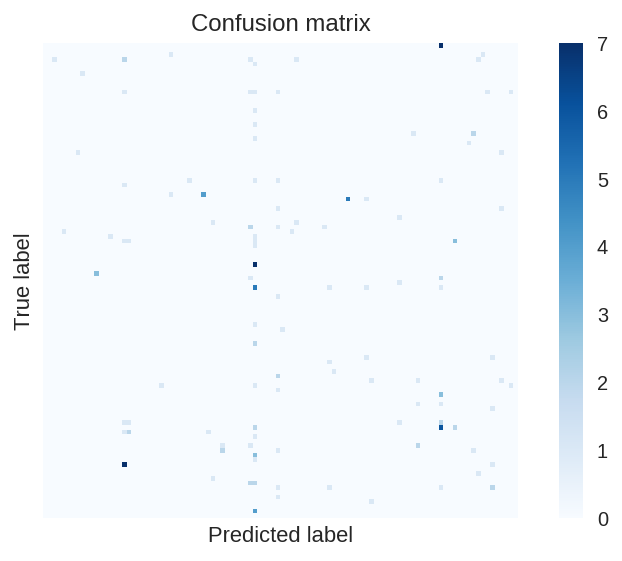

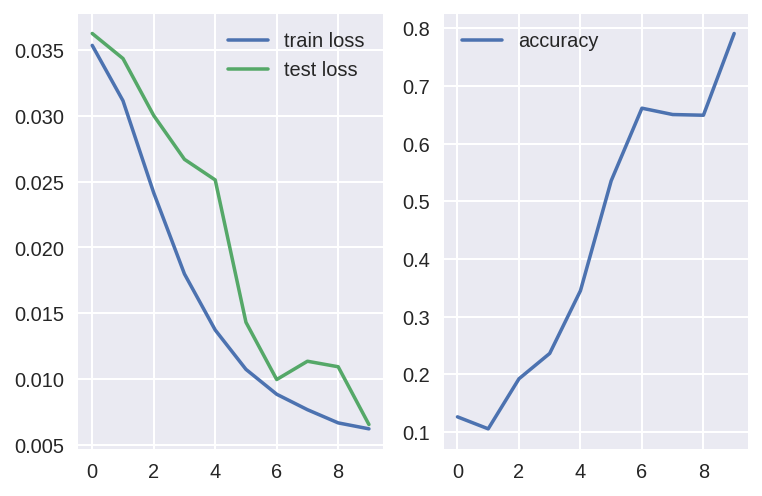

In [0]:
model = models.resnet152(pretrained=True) 
for param in model.parameters():
    param.requires_grad = False
# now configure the classifier and add it to the model
fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=102, bias=True),
    nn.LogSoftmax(dim=1)
  )
model.fc = fc
model, conf = train_and_test(model, optim.SGD(model.fc.parameters(), lr=0.1), 10)

epc 0	train loss:	0.0054	train time: 178.8s
				test loss:	0.00366	acc:	0.89609
epc 1	train loss:	0.00442	train time: 179.4s
				test loss:	0.0035	acc:	0.9022
epc 2	train loss:	0.00439	train time: 184.2s
				test loss:	0.00339	acc:	0.90465
epc 3	train loss:	0.00424	train time: 182.0s
				test loss:	0.00332	acc:	0.90342
epc 4	train loss:	0.00418	train time: 182.6s
				test loss:	0.00336	acc:	0.9022
epc 5	train loss:	0.00432	train time: 178.9s
				test loss:	0.00329	acc:	0.89853
epc 6	train loss:	0.00411	train time: 183.1s
				test loss:	0.00328	acc:	0.90098
epc 7	train loss:	0.00417	train time: 184.2s
				test loss:	0.00332	acc:	0.90098
epc 8	train loss:	0.00406	train time: 178.9s
				test loss:	0.00324	acc:	0.9022
epc 9	train loss:	0.00402	train time: 185.0s
				test loss:	0.00318	acc:	0.90098


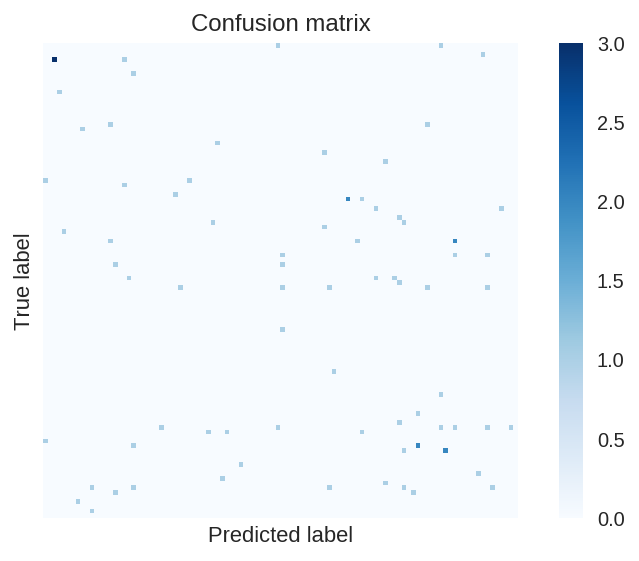

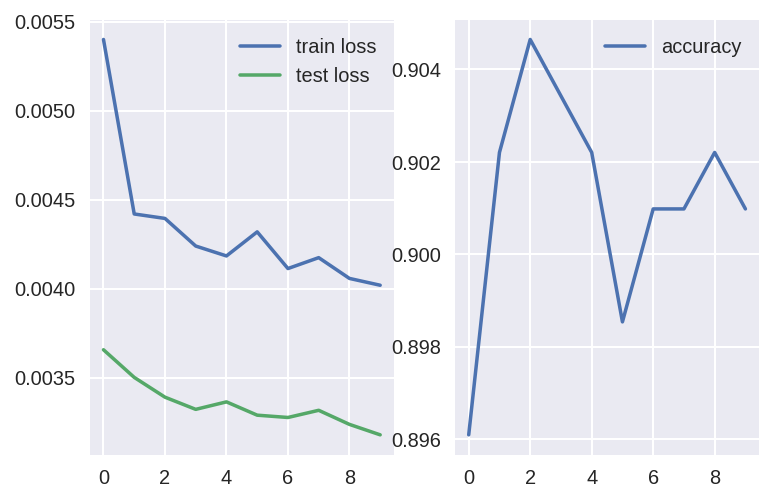

In [0]:
model, conf = train_and_test(model, optim.SGD(model.fc.parameters(), lr=0.005), 10)

epc 0	train loss:	0.00843	train time: 178.4s
				test loss:	0.00459	acc:	0.84963
epc 1	train loss:	0.00598	train time: 178.1s
				test loss:	0.00491	acc:	0.83863
epc 2	train loss:	0.00567	train time: 178.3s
				test loss:	0.0038	acc:	0.88875
epc 3	train loss:	0.00545	train time: 178.5s
				test loss:	0.00326	acc:	0.90342
epc 4	train loss:	0.00505	train time: 178.4s
				test loss:	0.00326	acc:	0.90954


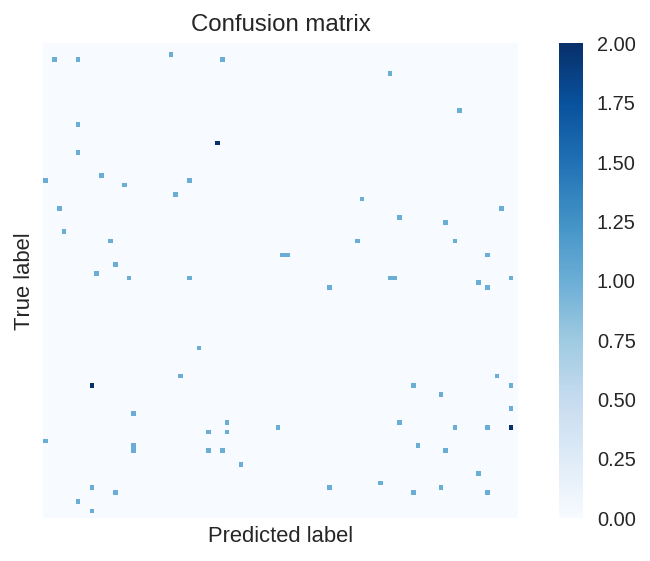

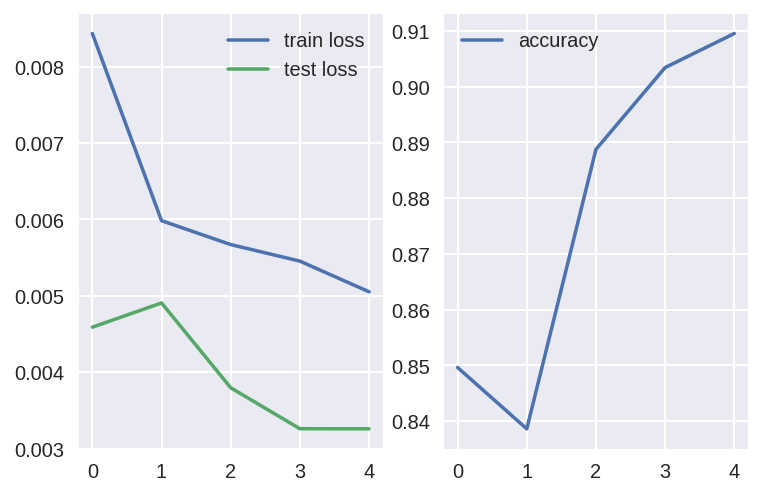

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.001), 5)

epc 0	train loss:	0.00425	train time: 174.3s
				test loss:	0.00342	acc:	0.89731
epc 1	train loss:	0.004	train time: 172.1s
new accuracy record, saving...
				test loss:	0.0032	acc:	0.89853
epc 2	train loss:	0.004	train time: 171.5s
				test loss:	0.00332	acc:	0.89609
epc 3	train loss:	0.00375	train time: 170.5s
new accuracy record, saving...
				test loss:	0.00306	acc:	0.90709
epc 4	train loss:	0.00372	train time: 169.5s
new accuracy record, saving...
				test loss:	0.00278	acc:	0.91687
epc 5	train loss:	0.00356	train time: 174.1s
				test loss:	0.00301	acc:	0.91443
epc 6	train loss:	0.00345	train time: 180.3s
				test loss:	0.00282	acc:	0.91565
epc 7	train loss:	0.00345	train time: 180.7s
new accuracy record, saving...
				test loss:	0.00263	acc:	0.9291
epc 8	train loss:	0.00326	train time: 180.4s
				test loss:	0.00262	acc:	0.92665
epc 9	train loss:	0.00311	train time: 180.5s
				test loss:	0.00268	acc:	0.92298


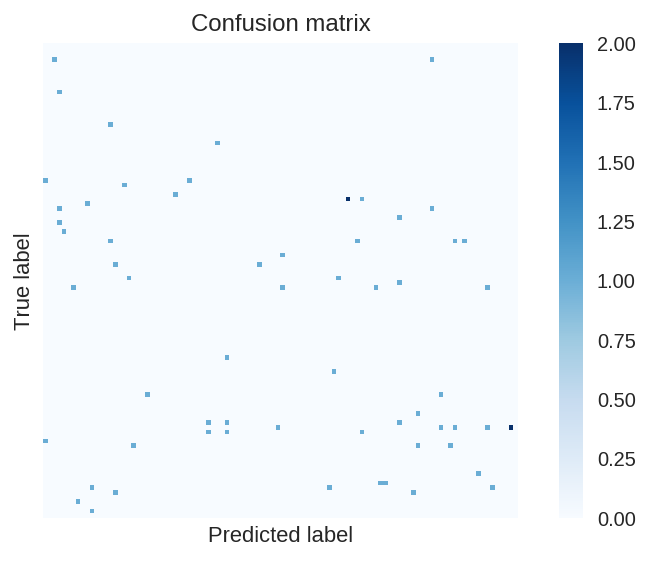

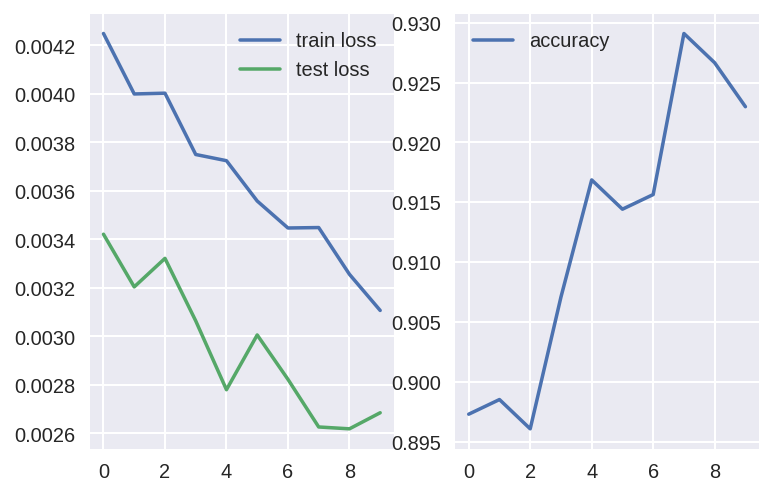

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.0001), 10, logging = True)

epc 0	train loss:	0.00314	train time: 181.5s
				test loss:	0.00259	acc:	0.91932
epc 1	train loss:	0.00286	train time: 182.0s
new accuracy record, saving...
				test loss:	0.00252	acc:	0.93032
epc 2	train loss:	0.00291	train time: 183.2s
new accuracy record, saving...
				test loss:	0.00238	acc:	0.93399
epc 3	train loss:	0.00294	train time: 182.6s
				test loss:	0.00234	acc:	0.93276
epc 4	train loss:	0.00279	train time: 181.9s
				test loss:	0.00244	acc:	0.92543
epc 5	train loss:	0.0028	train time: 181.6s
				test loss:	0.00234	acc:	0.93032
epc 6	train loss:	0.00269	train time: 180.9s
				test loss:	0.00242	acc:	0.93032
epc 7	train loss:	0.00276	train time: 180.7s
				test loss:	0.0024	acc:	0.93032
epc 8	train loss:	0.00254	train time: 181.8s
new accuracy record, saving...
				test loss:	0.00213	acc:	0.93765
epc 9	train loss:	0.00261	train time: 181.2s
				test loss:	0.00225	acc:	0.93276
epc 10	train loss:	0.00263	train time: 180.9s
				test loss:	0.00215	acc:	0.93399
epc 11	train loss

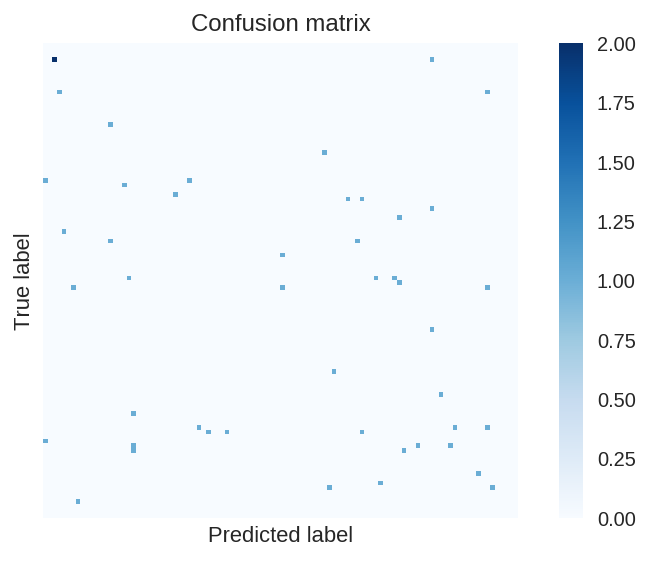

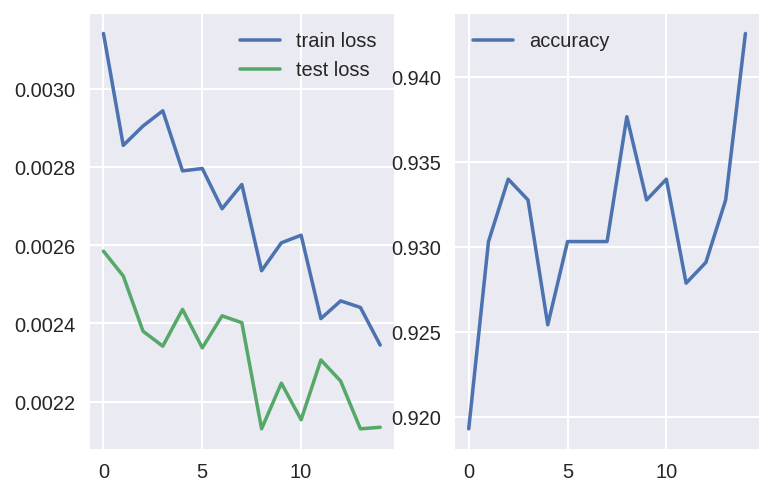

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.0001), 15, logging = True)

epc 0	train loss:	0.00264	train time: 179.2s
				test loss:	0.00206	acc:	0.93888
epc 1	train loss:	0.00248	train time: 179.0s
new accuracy record, saving...
				test loss:	0.00215	acc:	0.94132
epc 2	train loss:	0.0026	train time: 179.2s
				test loss:	0.00203	acc:	0.93643
epc 3	train loss:	0.00232	train time: 179.1s
				test loss:	0.00217	acc:	0.93276
epc 4	train loss:	0.00228	train time: 179.2s
				test loss:	0.00196	acc:	0.94132
epc 5	train loss:	0.00224	train time: 179.3s
new accuracy record, saving...
				test loss:	0.00192	acc:	0.94254
epc 6	train loss:	0.00221	train time: 179.4s
				test loss:	0.00192	acc:	0.9401
epc 7	train loss:	0.00226	train time: 179.3s
				test loss:	0.0021	acc:	0.93521
epc 8	train loss:	0.00211	train time: 179.3s
				test loss:	0.00198	acc:	0.93888
epc 9	train loss:	0.00201	train time: 179.2s
				test loss:	0.00198	acc:	0.93888
epc 10	train loss:	0.00212	train time: 179.3s
				test loss:	0.00194	acc:	0.94254
epc 11	train loss:	0.00219	train time: 179.1s
new

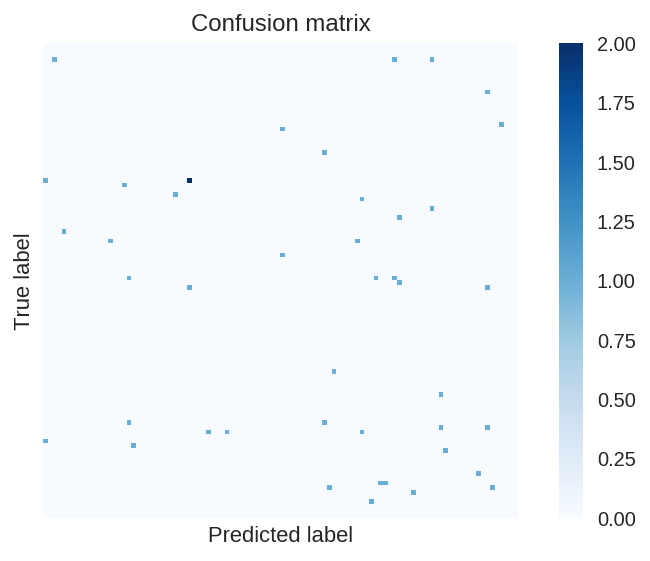

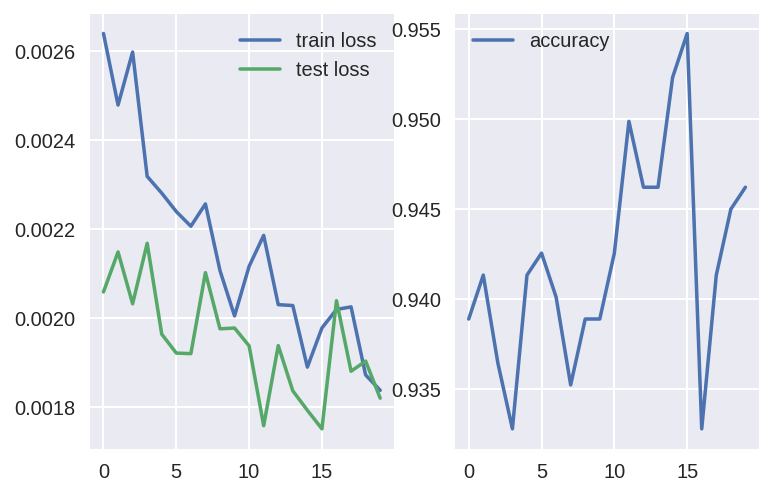

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.0001), 20, logging = True)

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.00001), 20, logging = True)

epc 0	train loss:	0.00174	train time: 179.4s
				test loss:	0.00171	acc:	0.94377
epc 1	train loss:	0.00165	train time: 179.8s
new accuracy record, saving...
				test loss:	0.00173	acc:	0.94866
epc 2	train loss:	0.00168	train time: 181.5s
				test loss:	0.00174	acc:	0.94743
epc 3	train loss:	0.00164	train time: 180.2s
				test loss:	0.00175	acc:	0.94866
epc 4	train loss:	0.00166	train time: 179.9s
				test loss:	0.00176	acc:	0.94621
epc 5	train loss:	0.00166	train time: 178.8s
new accuracy record, saving...
				test loss:	0.00174	acc:	0.95355
epc 6	train loss:	0.00155	train time: 178.5s
				test loss:	0.00175	acc:	0.94743
epc 7	train loss:	0.00161	train time: 178.5s
				test loss:	0.00169	acc:	0.94988
epc 8	train loss:	0.00154	train time: 178.6s
				test loss:	0.00169	acc:	0.9511
epc 9	train loss:	0.00159	train time: 178.4s
				test loss:	0.00168	acc:	0.94621
epc 10	train loss:	0.00164	train time: 178.3s
				test loss:	0.0017	acc:	0.94499
epc 11	train loss:	0.00152	train time: 178.7s
		

epc 0	train loss:	0.00222	train time: 173.2s
				test loss:	0.00204	acc:	0.93643
epc 1	train loss:	0.00209	train time: 171.0s
new accuracy record, saving...
				test loss:	0.00207	acc:	0.93888
epc 2	train loss:	0.00202	train time: 170.2s
				test loss:	0.00201	acc:	0.93888
epc 3	train loss:	0.002	train time: 169.4s
				test loss:	0.00203	acc:	0.93643
epc 4	train loss:	0.00202	train time: 170.5s
				test loss:	0.00201	acc:	0.93521
epc 5	train loss:	0.002	train time: 169.7s
				test loss:	0.00201	acc:	0.93888
epc 6	train loss:	0.00192	train time: 169.6s
				test loss:	0.00194	acc:	0.93888
epc 7	train loss:	0.00203	train time: 175.7s
				test loss:	0.00202	acc:	0.93765
epc 8	train loss:	0.00203	train time: 180.7s
				test loss:	0.00208	acc:	0.93154
epc 9	train loss:	0.00188	train time: 178.4s
				test loss:	0.00201	acc:	0.93888


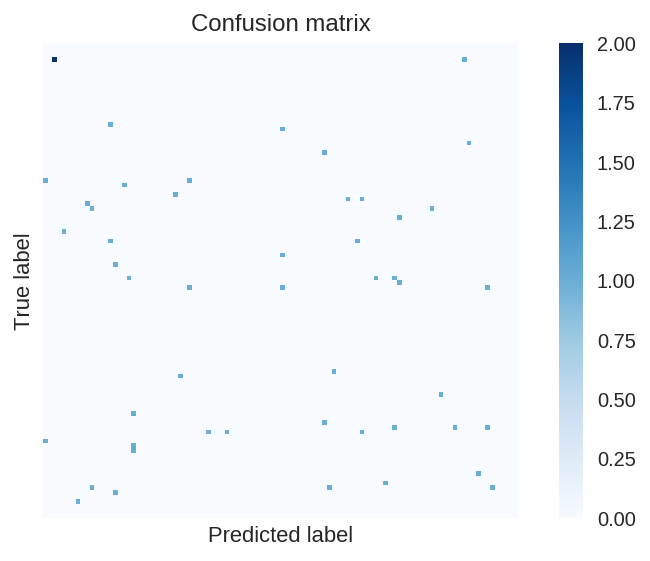

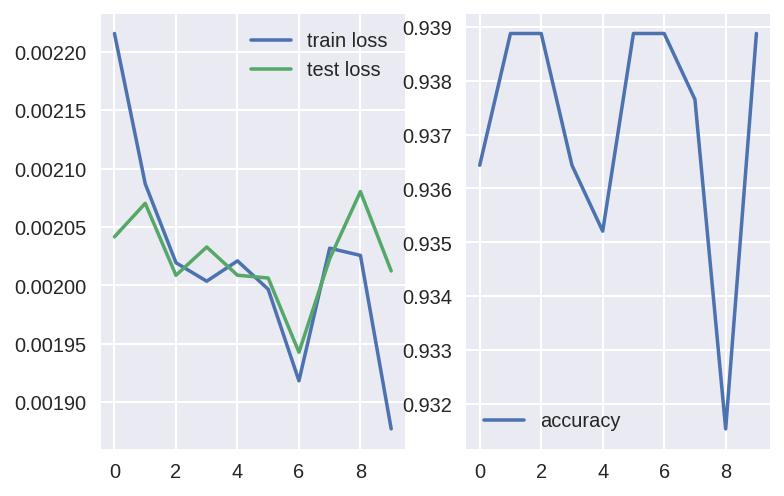

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.00001), 10, logging = True)

epc 0	train loss:	0.00198	train time: 178.1s
				test loss:	0.00198	acc:	0.93643
epc 1	train loss:	0.00194	train time: 180.4s
new accuracy record, saving...
				test loss:	0.00202	acc:	0.93888
epc 2	train loss:	0.00187	train time: 179.9s
				test loss:	0.00199	acc:	0.93765
epc 3	train loss:	0.00189	train time: 179.7s
new accuracy record, saving...
				test loss:	0.00196	acc:	0.9401
epc 4	train loss:	0.00192	train time: 177.9s
				test loss:	0.00196	acc:	0.93521
epc 5	train loss:	0.0019	train time: 180.0s
				test loss:	0.00196	acc:	0.93888
epc 6	train loss:	0.0019	train time: 179.0s
				test loss:	0.00203	acc:	0.93765
epc 7	train loss:	0.00189	train time: 177.2s
				test loss:	0.00203	acc:	0.9401
epc 8	train loss:	0.00186	train time: 182.9s
				test loss:	0.00204	acc:	0.93765
epc 9	train loss:	0.00193	train time: 177.1s
				test loss:	0.00194	acc:	0.93888


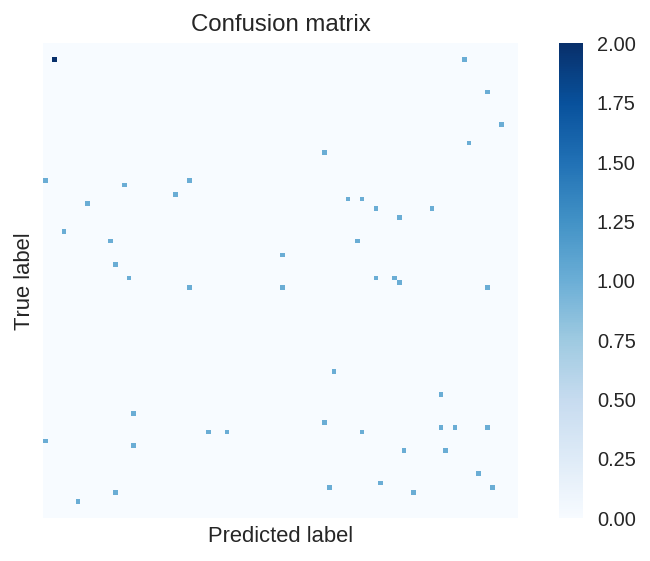

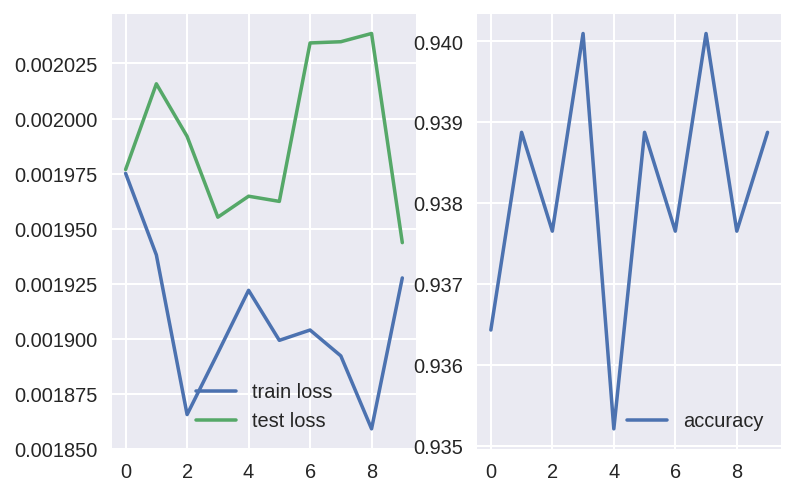

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.00001), 10, logging = True)

epc 0	train loss:	0.00189	train time: 180.9s
				test loss:	0.00196	acc:	0.93765
epc 1	train loss:	0.00196	train time: 178.8s
				test loss:	0.00205	acc:	0.93521
epc 2	train loss:	0.00193	train time: 186.4s
new accuracy record, saving...
				test loss:	0.00196	acc:	0.9401
epc 3	train loss:	0.00185	train time: 180.7s
				test loss:	0.00198	acc:	0.93399
epc 4	train loss:	0.00188	train time: 181.4s
				test loss:	0.00194	acc:	0.93399
epc 5	train loss:	0.00188	train time: 187.1s
				test loss:	0.00205	acc:	0.93521
epc 6	train loss:	0.00191	train time: 180.6s
				test loss:	0.00197	acc:	0.93888
epc 7	train loss:	0.002	train time: 182.4s
				test loss:	0.00194	acc:	0.9401
epc 8	train loss:	0.00192	train time: 182.5s
				test loss:	0.00196	acc:	0.93888
epc 9	train loss:	0.00181	train time: 173.6s
				test loss:	0.00199	acc:	0.93643
epc 10	train loss:	0.00185	train time: 171.5s
				test loss:	0.00195	acc:	0.93765
epc 11	train loss:	0.00186	train time: 171.0s
				test loss:	0.00195	acc:	0.93765

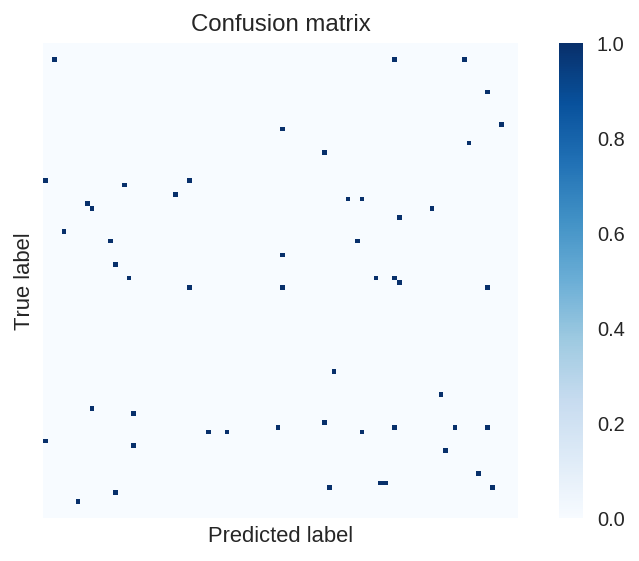

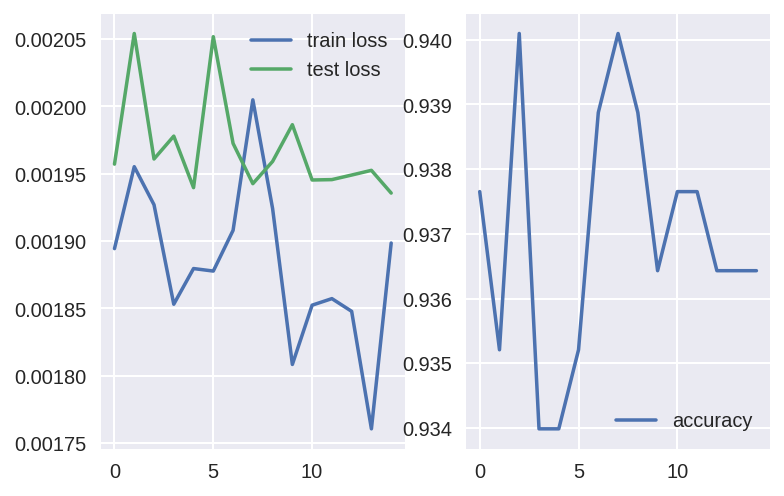

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.00001), 15, logging = True)

epc 0	train loss:	0.00185	train time: 177.5s
				test loss:	0.00193	acc:	0.93643
epc 1	train loss:	0.00183	train time: 182.0s
new accuracy record, saving...
				test loss:	0.00189	acc:	0.9401
epc 2	train loss:	0.00181	train time: 177.0s
				test loss:	0.00205	acc:	0.93888
epc 3	train loss:	0.00171	train time: 180.2s
				test loss:	0.00193	acc:	0.93765
epc 4	train loss:	0.00194	train time: 180.5s
				test loss:	0.00192	acc:	0.93888
epc 5	train loss:	0.00184	train time: 177.6s
new accuracy record, saving...
				test loss:	0.00192	acc:	0.94132
epc 6	train loss:	0.00179	train time: 179.4s
				test loss:	0.00197	acc:	0.9401
epc 7	train loss:	0.00178	train time: 178.1s
				test loss:	0.00187	acc:	0.94132
epc 8	train loss:	0.00183	train time: 184.3s
				test loss:	0.00194	acc:	0.93888
epc 9	train loss:	0.00185	train time: 181.2s
				test loss:	0.0019	acc:	0.9401
epc 10	train loss:	0.00178	train time: 178.6s
				test loss:	0.00197	acc:	0.93888
epc 11	train loss:	0.00174	train time: 186.1s
				

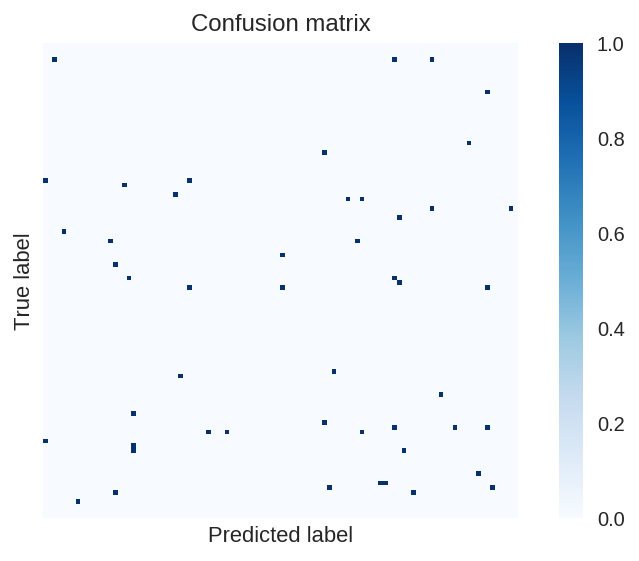

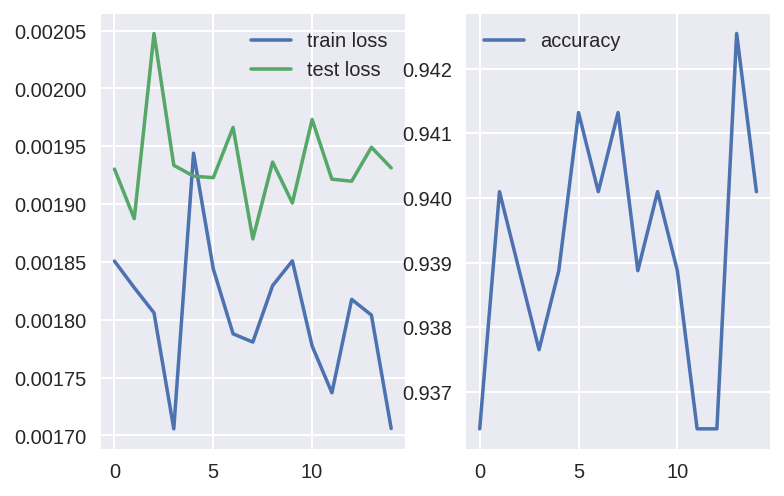

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.00001), 15, logging = True)

epc 0	train loss:	0.00216	train time: 181.1s
				test loss:	0.00205	acc:	0.93888
epc 1	train loss:	0.00205	train time: 174.2s
				test loss:	0.00199	acc:	0.93643
epc 2	train loss:	0.00198	train time: 173.2s
				test loss:	0.00202	acc:	0.94377
epc 3	train loss:	0.00202	train time: 171.2s
				test loss:	0.00211	acc:	0.93643
epc 4	train loss:	0.00193	train time: 171.6s
				test loss:	0.00192	acc:	0.9401
epc 5	train loss:	0.00202	train time: 171.1s
				test loss:	0.00191	acc:	0.94743
epc 6	train loss:	0.00183	train time: 170.2s
				test loss:	0.00194	acc:	0.94254
epc 7	train loss:	0.00186	train time: 171.1s
epc 8	train loss:	0.00183	train time: 170.9s
				test loss:	0.00194	acc:	0.94377
epc 9	train loss:	0.00172	train time: 175.9s
				test loss:	0.00195	acc:	0.94254
epc 10	train loss:	0.00183	train time: 176.9s
				test loss:	0.00193	acc:	0.9401
epc 11	train loss:	0.00191	train time: 175.5s
				test loss:	0.00202	acc:	0.93521
epc 12	train loss:	0.00188	train time: 176.5s
				test loss:	0.0

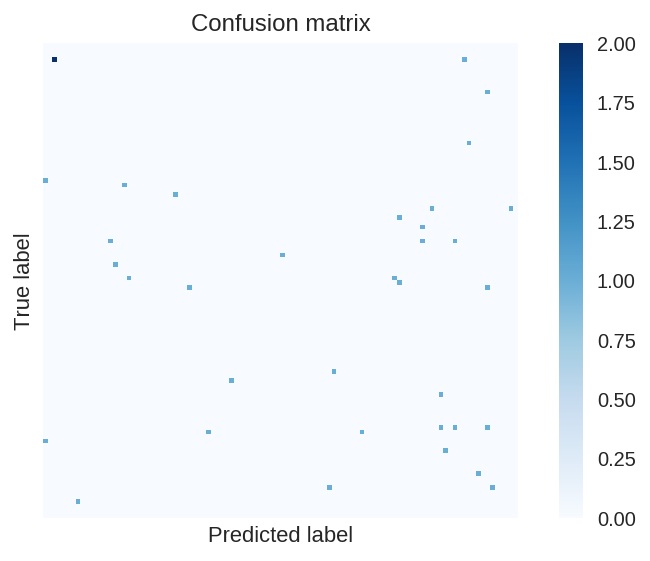

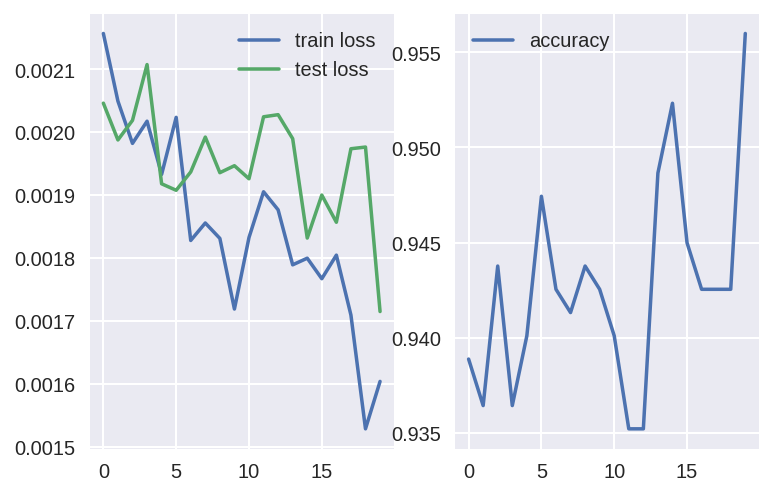

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.0001), 20)

In [0]:
torch.save(model.state_dict(), "model.pth")

epc 0	train loss:	0.00171	train time: 178.5s
				test loss:	0.00191	acc:	0.94988
epc 1	train loss:	0.00145	train time: 178.0s
				test loss:	0.00186	acc:	0.9511
epc 2	train loss:	0.00137	train time: 178.2s
				test loss:	0.00182	acc:	0.9511
epc 3	train loss:	0.00148	train time: 178.8s
				test loss:	0.00184	acc:	0.95355
epc 4	train loss:	0.0014	train time: 178.9s
				test loss:	0.0018	acc:	0.95355
epc 5	train loss:	0.00136	train time: 179.0s
				test loss:	0.00188	acc:	0.94743
epc 6	train loss:	0.00137	train time: 178.6s
				test loss:	0.00174	acc:	0.95599
epc 7	train loss:	0.00128	train time: 178.9s
				test loss:	0.00179	acc:	0.95232
epc 8	train loss:	0.00128	train time: 178.9s
				test loss:	0.00181	acc:	0.94866
epc 9	train loss:	0.00126	train time: 178.5s
				test loss:	0.00183	acc:	0.95721
epc 10	train loss:	0.00136	train time: 178.4s
				test loss:	0.00188	acc:	0.94866
epc 11	train loss:	0.00136	train time: 178.8s
				test loss:	0.0019	acc:	0.94866
epc 12	train loss:	0.00132	trai

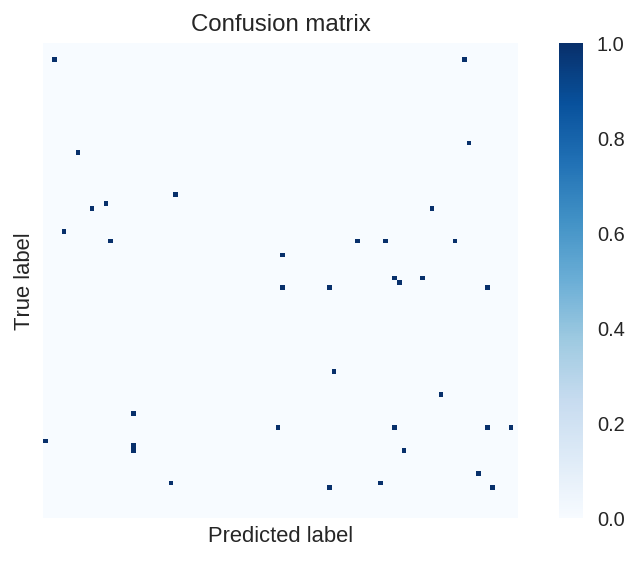

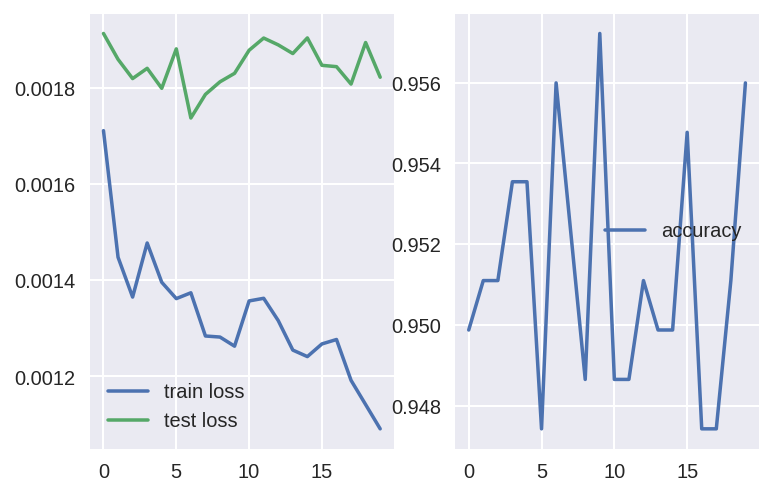

In [0]:
model, conf = train_and_test(model, optim.Adam(model.fc.parameters(), lr=0.0001), 20)

In [0]:
torch.save(model.state_dict(), "checkpoint.pth")
!ls -lah

total 878M
drwxr-xr-x 1 root root 4.0K Nov 25 01:24 .
drwxr-xr-x 1 root root 4.0K Nov 24 16:28 ..
-rw-r--r-- 1 root root 235M Nov 25 01:24 checkpoint.pth
drwxr-xr-x 4 root root 4.0K Nov 20 18:06 .config
drwx------ 4 root root 4.0K Nov  6 15:55 flower_data
-rw-r--r-- 1 root root 298M Nov  6 16:00 flower_data.zip
-rw-r--r-- 1 root root 298M Nov  6 16:00 flower_data.zip.1
-rw-r--r-- 1 root root  49M Nov 24 19:02 model.pth
drwxr-xr-x 2 root root 4.0K Nov 20 18:17 sample_data


In [0]:
# try restoring a resnet from a saved model and testing it
model = models.resnet152(pretrained=True) 
for param in model.parameters():
    param.requires_grad = False
# now configure the classifier and add it to the model
fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=102, bias=True),
    nn.LogSoftmax(dim=1)
  )
model.fc = fc
model.load_state_dict(torch.load("resnet152_95599.pth"))
test_only(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:04<00:00, 54199260.66it/s]


test loss: 0.0017149860271614746	acc:0.9559902200488998


In [0]:
for param in model.parameters():
    param.requires_grad = True

In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1)

model, conf = train_and_test(model, optim.SGD(model.fc.parameters(), lr=0.001), 20)
# even with batch size 1, this immediately gives CUDA error: oom

RuntimeError: ignored